<a href="https://colab.research.google.com/github/FabioMMaia/face_recognition_4models/blob/main/Modeling_LBP_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy.random import seed
import pickle
from tqdm import tqdm

import pytz
from datetime import datetime
from collections import Counter
import math

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [2]:
!pip install unidecode

def norm_text(txt):
  from unidecode import unidecode
  return unidecode(txt).replace(' ','_').lower()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
config_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/config/'
model_save_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/model/'
erro_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/error/'
log_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/log/'

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Modelos_Implementações')

In [6]:
import MLP as mlp # multilayer perceptron
import Multinomial_LogReg # regressão logística com alpha variavel (bissecao)
import R_LOG as r_log # regressão logística com alpha fixo
import SVM_OVR # SVM one-versus-rest
import ANN

In [7]:
# import importlib

# importlib.reload(ANN)
# importlib.reload(mlp)
# importlib.reload(Multinomial_LogReg)
# importlib.reload(r_log)
# importlib.reload(SVM_OVR)
# importlib.reload(ANN)

In [8]:
class logfile():

  def __init__(self, diretorio):
    self.diretorio=diretorio

  def start(self, tag, use_dateref=True):
    if use_dateref:
      tag = tag + '_' + datetime.now(pytz.timezone('America/Bahia')).strftime("%Y%m%d")
    self.save_file = open(self.diretorio +  tag + '.txt', 'w')
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Execução em:', data_atual, file=self.save_file)
    
  def end(self):
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Fim de Execução em:', data_atual, file=self.save_file)
    self.save_file.close()

In [9]:
# Visualize Dataset

In [10]:
def generate_image_db(keep_images):
  import zipfile
  from skimage.transform import resize


  imagens_path = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/CelebA/img_align_celeba.zip'
  imgzip = zipfile.ZipFile(imagens_path)
  inflist = imgzip.infolist()
  all_images = {}

  for f in tqdm(inflist):
    file_name = f.filename.split('/')[1]
    if file_name in keep_images:
      if '.jpg' in file_name:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img_resize = resize(np.array(img), (128, 128))
        all_images[file_name] = [img_resize]

  return all_images

def plt_samples(imgs):
  # faces que foram reconhecidas pelo viola jones
  fig, axes = plt.subplots(1,5, figsize=(10,10))

  imgs= pd.DataFrame(imgs)

  for (i,row), ax in zip(imgs.head(8).iterrows(), axes.ravel()): 
    ax.axis('off')
    ax.imshow(row[0], cmap=plt.cm.gray)

def visualize_5photos(y):
  amostra= generate_image_db(y.sample(5).index)
  amostra_df = pd.DataFrame(amostra).T.reset_index()
  plt_samples(amostra_df)

# Carregando Dataset - LBP

In [11]:
n_classes=5
ref = 'LBP' 
tag= 'lbp' + '_'+ str(n_classes) + '_classes'


with open(r'/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/X_y_' + tag +'.obj', "rb") as f:
    X,y = pickle.load(f)

100%|██████████| 202600/202600 [00:00<00:00, 360685.03it/s]


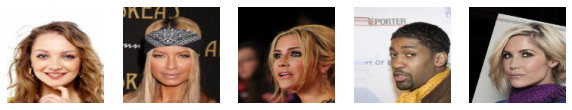

In [12]:
visualize_5photos(y)

In [13]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (160, 2500)
y shape: (160,)


In [14]:
# transformar categorias em one-hot-encoding: Saída
saida = y.max()+1
print("Quantidade de pessoas:",saida)
target = keras.utils.to_categorical(y, saida)

Quantidade de pessoas: 5


# Train x Test

In [15]:
def train_test_separation(X, y):
  x_train, x_test, y_train_n, y_test_n = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

  y_train = target[y.index.isin(y_train_n.index).flatten(),:]
  y_test= target[y.index.isin(y_test_n.index).flatten(),:]

  assert y_train.shape[0]== y_train_n.shape[0]
  assert y_test.shape[0]== y_test_n.shape[0]

  print('Shape',x_train.shape, x_test.shape, y_train.shape, y_test.shape,  y_train_n.shape, y_test_n.shape)

  return x_train, x_test, y_train_n, y_test_n, y_train, y_test

In [16]:
def apply_PCA(n_pca, x_train,x_test, norm_entry=False):

  if norm_entry:
    x_train = (x_train - x_train.mean(axis=0))/  x_train.std(axis=0)
    x_test = (x_test - x_train.mean(axis=0))/  x_train.std(axis=0)
  else:
    pass

  pca = PCA(n_components=n_pca, random_state=42)
  pca.fit(x_train)

  print('variancia explicada:', sum(pca.explained_variance_ratio_))
  x_train_pca = pca.transform(x_train)
  x_test_pca = pca.transform(x_test)

  x_train_pca_norm = (x_train_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)
  x_test_pca_norm = (x_test_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)

  return x_train_pca_norm, x_test_pca_norm

In [17]:
X_train, X_test, y_train_n, y_test_n, y_train, y_test = train_test_separation(X,y)

Shape (112, 2500) (48, 2500) (112, 5) (48, 5) (112,) (48,)


In [18]:
X_train_pca, X_test_pca = apply_PCA(n_pca=50, x_train=X_train, x_test=X_test,norm_entry=True)

variancia explicada: 0.608084225828258


In [19]:
def unpack_dict_as_str(dicionario):
  string=''

  for k,v in dicionario.items():
    string= string + str(k) + ':[ '
    try:
      for v_ in v:
        string= string + str(v_) + ' '
      string= string+'] '
    except:
      string= string + str(v) + '] '
  return string.strip()

# unpack_dict_as_str({'a':[2,5,6], 'b':[6,7]})

In [24]:
def pipeline_integrated_onedim(nome_do_modelo, #nome do modelo
                               classifier, # classificador
                               param_iteracao, # parametro iteração - deve conter um dicionario com a lista de valores a ser iterado
                               param_fixo,  # parametro fixo e respectivo valor (uma lista)
                               data, # dicionario de treino e teste
                               kf= KFold(n_splits=5, shuffle=True, random_state=42),
                               neural_network=False): #kfold

  print('Pipeline de testes para o modelo:', nome_do_modelo)
  X_train = data['X_train']
  X_test = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

  log={}
  log['exec_time'] = 'Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S"))
  log['model_name'] = nome_do_modelo
  log['parametro_fixo'] = '{}:[{}]'.format(param_fixo[0], param_fixo[1])
  log['parametro_variavel'] = unpack_dict_as_str(param_iteracao)
  log['kfold'] = kf

  best_acc_val = -1
  best_model=None
  best_param = None
  it=0

  for parametro, valores in param_iteracao.items():
    cv_report = {}
    for valor in valores:
      it+=1

      cv_report['cv_results_'+str(it)] = {}
      print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
      print("====================================================================")
      print('iteração:{}'.format(it))
      param = {parametro:valor}
      param[param_fixo[0]] = param_fixo[1]
      print('Testando parametros:\n', unpack_dict_as_str(param))
      print("====================================================================")
      
      cv_report['cv_results_'+str(it)]['cv_param']= unpack_dict_as_str(param)

      for k_index,(train_index, val_index) in enumerate(kf.split(X_train)):
        print('cross-validation: {}'.format(k_index))
        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

        # Ajusta o parâmetro usando o dicionário
        for k,v in param.items():
          setattr(classifier,k,v)
        
        if neural_network:
          classifier.fit(X_train_kf, y_train_kf,[X_val_kf,y_val_kf])
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf.argmax(axis=1))
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf.argmax(axis=1))
          acc_test = accuracy_score(classifier.predict(X_test), y_test.argmax(axis=1))
        else:
          classifier.fit(X_train_kf, y_train_kf)
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf)
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf)
          acc_test = accuracy_score(classifier.predict(X_test), y_test)


        if acc_val>best_acc_val:
          best_model=classifier
          best_param = param
          k_index_best = k_index
          best_acc_val=acc_val

        cv_report['cv_results_'+str(it)]['acc_train_'+str(k_index)] = acc_train
        cv_report['cv_results_'+str(it)]['acc_val_'+ str(k_index)] = acc_val
        cv_report['cv_results_'+str(it)]['acc_test_'+ str(k_index)] = acc_test

    log['cv_report']= cv_report

    if neural_network:
      best_model.fit(X_train, y_train,[X_test,y_test])
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train.argmax(axis=1))
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test.argmax(axis=1))
    else:
      best_model.fit(X_train, y_train)
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train)
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test)
    

    print('Melhor acurácia no validação obtida com os parametros {}. Treino final: {:.4f} Teste:{:.4f}'.format(unpack_dict_as_str(best_param),acc_train_best_model, acc_test_best_model))
    print('Fim da Execução: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
    
    log['melhor_modelo_obj'] = best_model
    log['best_param_k_fold'] = unpack_dict_as_str(best_param)
    log['acc_train_best_model'] = acc_train_best_model
    log['acc_test_best_model'] = acc_test_best_model

    return log

def dictlog_to_flat_table(log):
  log_i = pd.DataFrame(log, index=[norm_text(modelo)])
  cv_log_i = pd.DataFrame(log['cv_report']).T.reset_index().assign(modelo = norm_text(modelo))
  cv_log_i = pd.merge(log_i,cv_log_i, left_index = True , right_on = 'modelo', how='outer').drop(columns='cv_report')
  return cv_log_i

# Teste com Modelos

In [21]:
logs = pd.DataFrame()

Regressão Logística

In [25]:
modelo = 'Regressão Logística Multinomial Passo Fixo'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg(),
                          param_iteracao= {'alpha':[0.01, 0.1]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,iagnore_index=True)

Pipeline de testes para o modelo: Regressão Logística Multinomial Passo Fixo
Execução em: 21/01/2023 10:17:51
iteração:1
Testando parametros:
 alpha:[ 0.01] theta:[ 0.001]
cross-validation: 0


KeyError: ignored

In [ ]:
modelo = 'Regressão Logística Multinomial com Bisseção'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg_bissecao(),
                          param_iteracao= {'itmax_bissec':[5, 20]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

# SVM

In [ ]:
modelo = 'SVM Classificador Kernel RBF C=1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.01, 0.1,1]},
                          param_fixo=['C',1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

In [ ]:
modelo = 'SVM Classificador Kernel RBF C=100'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.01, 0.1,1]},
                          param_fixo=['C',100],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df)

# MLP

In [ ]:
modelo = 'MultiLayer Perceptron alpha 0.1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  ANN.RNA(),
                          param_iteracao= {'h':[10,25,50,100]},
                          param_fixo=['alpha',0.1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n},
                          neural_network=True)

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

In [ ]:
pd.set_option('display.max_columns', None)
logs.head(3)

# Informações Melhor/Pior Modelo

In [ ]:
label = tag + '_log_full'

logs.to_excel(log_dir +label + '.xlsx')

In [ ]:
def save_error(label):
  errorFile = open(erro_dir +label + '.txt', 'w') 
  print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")) , file=errorFile)

  out=''
  for i,r in melhor_modelo_infos.filter(like='acc').T.reset_index().iterrows():
    out=out + str(r['index']) + ':' + str(r[0]) + '\n'
  print(out, file=errorFile)
  errorFile.close()

In [ ]:
label = tag + '_' + 'melhor'

melhor_modelo_infos = logs.sort_values(by='acc_test_best_model',ascending=False).head(1)

# Salva mehlhor modelo
melhor_modelo = melhor_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(melhor_modelo, fp)

# Salva o erro
save_error(label)

#Salva o config
melhor_modelo_infos.drop(columns = melhor_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')

In [ ]:
label = tag + '_' + 'pior'

pior_modelo_infos = logs.sort_values(by='acc_test_best_model',ascending=False).tail(1)

# Salva pior modelo
pior = pior_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(pior, fp)

# Salva o erro
save_error(label)

#Salva o config
melhor_modelo_infos.drop(columns = pior_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')